# Magda's exercise for class 8 - matmul

## Basic imports

can use `math, torch, gzip, pickle, fastai.datasets, pathlib, matplotlib`

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [101]:
#export
import gzip
from pathlib import Path
import torch
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt

## Get data

* Get MNIST pkl data
* Can use fastai datasets

In [3]:
data_path = Path('/home/magda/datasets/mnist')
data_gzip = data_path/'mnist.pkl.gz'

In [4]:
with gzip.open(data_gzip, 'rb') as data_file:
    (train_x, train_y), (valid_x, valid_y), _ = pickle.load(data_file, encoding='latin-1')

In [5]:
train_x.shape, train_y.shape, valid_x.shape, valid_y.shape

((50000, 784), (50000,), (10000, 784), (10000,))

Make data pytorch tensors

In [6]:
(train_x, train_y, valid_x, valid_y) = [torch.tensor(x) for x in (train_x, train_y, valid_x, valid_y)]

In [7]:
train_x.shape

torch.Size([50000, 784])

**Plot an example**

In [8]:
mpl.rcParams['image.cmap']

'viridis'

In [9]:
img = train_x[0].view(28, -1)

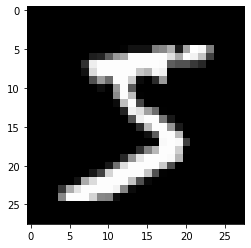

In [10]:
plt.imshow(img, cmap='gray')

**Plot multiple images**

In [11]:
idxs = torch.multinomial(torch.arange(train_x.shape[0], dtype=float), 9)
imgs = train_x[idxs]
imgs.shape

torch.Size([9, 784])

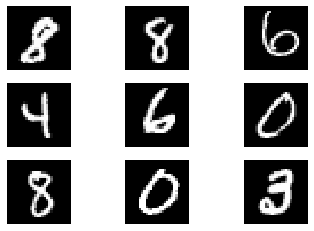

In [12]:
default_cmap = mpl.rcParams['image.cmap']
mpl.rcParams['image.cmap'] = 'gray'
fig, axs = plt.subplots(3,3)
for i, img in enumerate(imgs):
    row = i // 3
    col = i % 3
    axs[row, col].imshow(img.view(28,-1))
    axs[row, col].axis('off')

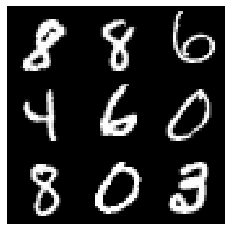

In [15]:
imgs_tmp = imgs.view(3, 3, 28, -1).permute(0,2,1,3)
plt.imshow(imgs_tmp.reshape(3*28, 3*28))
plt.axis('off');

## Initial python model

random weights and bias

In [88]:
#export
def test_equal(a, b):
    assert torch.equal(a,b), f'{a} and {b} are not equal'

def test_near(a, b, rtol=1e-5, atol=1e-08):
    assert torch.allclose(a, b, rtol, atol), f'{a} and {b} are not near'

In [14]:
in_num, in_dim = train_x.shape
out_dim = 10
weights = torch.normal(0, 1, (in_dim, out_dim))
bias = torch.zeros(10)
weights, bias

(tensor([[ 0.9948,  0.4246, -0.6861,  ..., -0.5676,  0.7435, -0.6193],
         [-1.2735, -1.2490, -0.3699,  ...,  0.1722,  0.7098, -1.3385],
         [-1.1258, -2.7229,  0.2505,  ..., -2.3556, -2.0131, -1.4079],
         ...,
         [-0.0960,  0.3707,  0.8756,  ...,  0.5531, -0.4226, -1.2615],
         [ 1.3133,  0.3286, -0.6915,  ..., -1.5479,  0.2563,  0.4037],
         [ 1.1647,  0.8215,  0.2471,  ..., -1.4835, -0.0396,  2.0746]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

**matmul 3 loops**

In [92]:
def matmul(a, b):
    ra, ca = a.shape
    rb, cb = b.shape
    assert ca==rb, f'incompatible shapes, cols a = {ca}, rows b = {rb}'
    out = torch.zeros((ra, cb), dtype=torch.float)
    for i in range(ra):
        for j in range(cb):
            for k in range(ca):
                out[i, j] += a[i, k] * b[k, j]
    return out

In [28]:
a = torch.rand(3,5)
b = torch.rand(5,6)

tensor([[0.9620, 1.6104, 1.7631, 1.3487, 1.1272, 1.7076],
        [0.7491, 1.3150, 1.1363, 1.0579, 0.9332, 1.1417],
        [1.0063, 1.8299, 1.9527, 1.3530, 1.1959, 1.5620]])

In [93]:
test_near(a@b, matmul(a,b), 1e-6)
%timeit matmul(a,b)

1.56 ms ± 15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


**matmul 2 loops**

In [94]:
def matmul(a, b):
    ra, ca = a.shape
    rb, cb = b.shape
    assert ca==rb, f'incompatible shapes, cols a = {ca}, rows b = {rb}'
    out = torch.zeros((ra, cb), dtype=torch.float)
    for i in range(ra):
        for j in range(cb):
            out[i, j] = (a[i,:] * b[:,j]).sum()
    return out    

In [95]:
test_near(a@b, matmul(a,b), 1e-6)
%timeit matmul(a,b)

308 µs ± 4.37 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


**matmul 1 loop**

In [96]:
def matmul(a, b):
    ra, ca = a.shape
    rb, cb = b.shape
    assert ca==rb, f'incompatible shapes, cols a = {ca}, rows b = {rb}'
    out = torch.zeros((ra, cb), dtype=torch.float)
    for i in range(ra):
        out[i, :] = (a[i][:,None] * b).sum(dim=0)
    return out    

In [97]:
test_near(a@b, matmul(a,b), 1e-6)
%timeit matmul(a,b)

62.7 µs ± 431 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Export

In [104]:
!python notebook2script.py 01Magda_matmul.ipynb

Converted 01Magda_matmul.ipynb to exp/nb_01Magda.py
